In [45]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans
from sklearn.neighbors import KNeighborsClassifier
from sklearn.cross_validation import KFold
import csv
import seaborn as sns
plt.rc('figure', figsize=[16,10])

In [46]:
traindf = pd.read_csv('train.csv')
testdf = pd.read_csv('test.csv')

traindf.head()

,label,pixel0,pixel1,pixel2,pixel3,pixel4,pixel5,pixel6,pixel7,pixel8,...,pixel774,pixel775,pixel776,pixel777,pixel778,pixel779,pixel780,pixel781,pixel782,pixel783
0,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,4,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [47]:
testdf.head()

,pixel0,pixel1,pixel2,pixel3,pixel4,pixel5,pixel6,pixel7,pixel8,pixel9,...,pixel774,pixel775,pixel776,pixel777,pixel778,pixel779,pixel780,pixel781,pixel782,pixel783
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [48]:
xdata = traindf.drop(['label'], axis=1).values
ydata = traindf['label'].values

pca = PCA(n_components=15)
pca.fit(xdata)
print(sum(pca.explained_variance_ratio_))

0.580516062686


In [49]:
X = pca.transform(xdata)
ypred = KMeans(n_clusters=10).fit_predict(X)

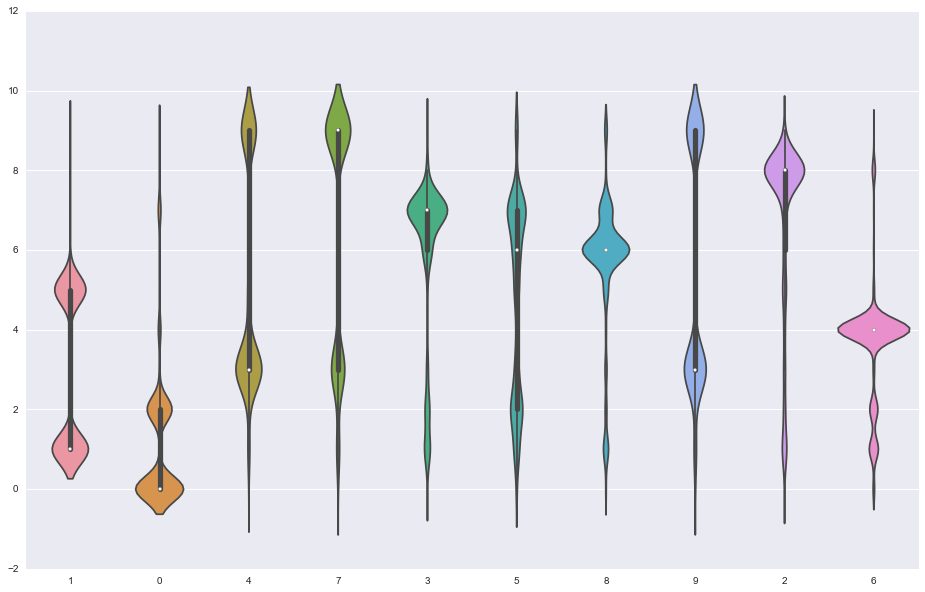

In [50]:
sns.violinplot(ydata, ypred)

Looks like K-means clustering isn't effective for *all* labels - maybe knn will be better.

In [51]:
neigh = KNeighborsClassifier(n_neighbors=3)
neigh.fit(X, ydata) 

KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski',
           metric_params=None, n_jobs=1, n_neighbors=3, p=2,
           weights='uniform')

In [52]:
scores = []
for train, test in KFold(n=len(ydata), n_folds=4, shuffle=True):
    neigh = KNeighborsClassifier(n_neighbors=3)
    neigh.fit(X[train], ydata[train])
    scores.append(neigh.score(X[test], ydata[test]))
print scores

[0.95609523809523811, 0.95323809523809522, 0.95447619047619048, 0.95152380952380955]


In [58]:
testdata = testdf.values
XVal = pca.transform(testdata)
predictions = neigh.predict(XVal)

ImageId = range(1, len(predictions)+1)

predictions_file = open("avrknn.csv", "wb")
open_file_object = csv.writer(predictions_file)
open_file_object.writerow(['ImageId', 'Label'])
open_file_object.writerows(zip(ImageId, predictions))
predictions_file.close()